In [1]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import os
from dotenv import load_dotenv
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.cluster import KMeans, Birch
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from hdbscan import HDBSCAN
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle as pkl
import json
import random

/home/user/Git/ecommerce-segments/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.insert(0, '../src/torch_helpers')

from autoencoder_binary import AutoEncoder, AETrainer
from encoding_classifier import EncodingClassifier, ClfTrainer
from lrp import LinearLRP

In [3]:
RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Reading Data

In [4]:
# Curry function to initialize postgres engine and return read_query function

def make_read_query(protocol=None, user=None, password=None, host=None, port=None, db=None):
    load_dotenv()
    
    protocol = protocol if protocol else 'postgresql+psycopg2'
    user = user if user else os.environ.get('POSTGRES_USER')
    password = password if password else os.environ.get('POSTGRES_PASSWORD')
    host = host if host else 'localhost'
    port = port if port else 5432
    db = db if db else os.environ.get('POSTGRES_DB')
    
    db_url = f'{protocol}://{user}:{password}@{host}:{port}/{db}'
    engine = create_engine(db_url)

    def read_query(query, verbose=True):
        if verbose:
            print(query, '\n')
            
        with engine.connect() as conn:
            df = sqlio.read_sql_query(query, conn)

        return df

    return read_query

In [5]:
read_query = make_read_query()

In [6]:
users_enriched = read_query("SELECT * FROM users_enriched")
users_enriched.head()

SELECT * FROM users_enriched 



,id,age,gender,country,city,traffic_source,created_at,first_order_timestamp,last_order_timestamp,days_to_activation,...,fav_category,fav_cat_purchases,fav_cat_avg_item_value,fav_cat_freq_strength,fav_cat_spending_strength,order_items,loyalty_segment,order_value_segment,category_choice_segment,lifetime_status
0,56219,60,F,United States,Philadelphia,Facebook,2019-01-02 00:06:00,2021-05-27 23:07:12,2021-05-27 23:07:12,876.0,...,Jeans,1.0,74.99,0.00,0.000000,"{""(70373,\""WranglerÂ® Booty Up Stretch Jean fo...",One-Off Purchasers,None,None,None
1,9418,69,F,United Kingdom,Cardiff,Search,2019-01-02 00:36:00,2021-07-30 12:35:12,2023-04-21 14:50:59,940.0,...,Outerwear & Coats,1.0,399.00,0.50,0.900677,"{""(90353,\""Colleen Skirt Slip\"",Women,Intimate...",New Repeat Customer (High Days-to-Order),Ordering High Value Items,None,None
2,21731,65,F,China,Harbin,Email,2019-01-02 01:47:00,2023-09-17 22:23:37,2023-09-17 22:23:37,1719.0,...,Blazers & Jackets,1.0,169.98,0.25,0.696811,"{""(27173,\""Modadorn New Arrivals Spring & fall...",One-Off Purchasers,None,None,None
3,39594,17,M,China,Shenzhen,Search,2019-01-02 03:00:00,2019-02-11 03:06:43,2019-10-25 02:29:03,40.0,...,Fashion Hoodies & Sweatshirts,1.0,51.96,0.50,0.722168,"{""(49470,\""Billabong Men's Semi-Button Up Stri...",New Repeat Customer (Mid Days-to-Order),Ordering Low Value,None,None
4,2000,30,F,China,Hefei,Search,2019-01-02 03:19:00,NaT,NaT,NaN,...,None,NaN,NaN,NaN,NaN,None,Never Ordered,None,None,None


In [7]:
order_items_enriched = read_query("SELECT * FROM order_items_enriched")
order_items_enriched.head()

SELECT * FROM order_items_enriched 



,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,...,product_category,product_department,product_brand,product_name,distribution_center,user_age,user_gender,user_county,user_city,user_traffic_source
0,1,1,1,2953,3,Shipped,2022-07-20 10:32:05,2022-07-20 16:42:00,NaT,NaT,...,Active,Women,Tommy Hilfiger,Tommy Hilfiger Women's 3 Pack Sports Crew,Memphis TN,62,F,South Korea,Bucheon City,Search
1,2,1,1,4731,7,Shipped,2022-07-20 11:05:38,2022-07-20 16:42:00,NaT,NaT,...,Jeans,Women,Joe's Jeans,Joe's Jeans Women's Skinny Jeans,Port Authority of New York/New Jersey NY/NJ,62,F,South Korea,Bucheon City,Search
2,3,1,1,7656,9,Shipped,2022-07-19 11:29:28,2022-07-20 16:42:00,NaT,NaT,...,Blazers & Jackets,Women,eVogues Apparel,Plus size Button Closure Cropped Bolero Jacket...,New Orleans LA,62,F,South Korea,Bucheon City,Search
3,4,2,2,25774,11,Complete,2022-02-20 10:28:57,2022-02-22 12:23:00,2022-02-23 18:29:00,NaT,...,Underwear,Men,Tommy Bahama,Tommy Bahama Tropical Print Boxer Short,Los Angeles CA,65,M,Brasil,Franca,Organic
4,5,3,3,22308,13,Processing,2023-04-23 09:04:57,NaT,NaT,NaT,...,Pants,Men,Dockers,Dockers Men's Limited Offer D2 Stretch Khaki Pant,Philadelphia PA,16,M,United States,Hallandale Beach,Organic


In [8]:
order_items_enriched.columns

Index(['id', 'order_id', 'user_id', 'product_id', 'inventory_item_id',
       'status', 'created_at', 'shipped_at', 'delivered_at', 'returned_at',
       'sale_price', 'cost', 'product_category', 'product_department',
       'product_brand', 'product_name', 'distribution_center', 'user_age',
       'user_gender', 'user_county', 'user_city', 'user_traffic_source'],
      dtype='object')

In [9]:
order_items_enriched.product_category.unique()

array(['Active', 'Jeans', 'Blazers & Jackets', 'Underwear', 'Pants',
       'Sleep & Lounge', 'Swim', 'Sweaters', 'Skirts', 'Shorts',
       'Accessories', 'Fashion Hoodies & Sweatshirts',
       'Suits & Sport Coats', 'Tops & Tees', 'Socks', 'Outerwear & Coats',
       'Dresses', 'Jumpsuits & Rompers', 'Maternity', 'Intimates',
       'Pants & Capris', 'Leggings', 'Plus', 'Socks & Hosiery', 'Suits',
       'Clothing Sets'], dtype=object)

In [10]:
order_items_enriched.status.value_counts()

status
Shipped       54440
Complete      45609
Processing    36388
Cancelled     27090
Returned      18232
Name: count, dtype: int64

# Calculating Features

In [62]:
def calc_categorical_leanings(order_items_enriched: pd.DataFrame, user_gender: str) -> pd.DataFrame:
    order_items_filtered = order_items_enriched.loc[order_items_enriched.user_gender==user_gender]\
                                              .loc[~order_items_enriched.status.isin(['Cancelled', 'Returned'])]\
                                 
    X_cats = order_items_filtered.pivot_table(index='user_id', 
                                              columns=['product_category'], 
                                              values='id', 
                                              aggfunc='count', 
                                              fill_value=0)
   
    repeat_purchasers = users_enriched.loc[users_enriched.n_orders>1]
    repeat_purchasers_idx = list(set(X_cats.index).intersection(repeat_purchasers.id))
    X_cats = X_cats.loc[repeat_purchasers_idx]

    X_aggs = order_items_filtered.groupby('user_id')['sale_price'].agg(['count', 'sum'])
    X_aggs['avg_item_price'] = X_aggs['sum'] / X_aggs['count']

    X_cats = X_cats.apply(lambda x: x / x.sum(), axis=1)
    
    return X_cats

In [63]:
X_cats_m = calc_categorical_leanings(order_items_enriched, 'M')
X_cats_f = calc_categorical_leanings(order_items_enriched, 'F')

In [64]:
print('Category Purchases Male', f'Columns: {X_cats_m.columns}', f'Shape: {X_cats_m.shape}', sep='\n')
print('\nCategory Purchases Female', f'Columns: {X_cats_f.columns}', f'Shape: {X_cats_f.shape}', sep='\n')

Category Purchases Male
Columns: Index(['Accessories', 'Active', 'Fashion Hoodies & Sweatshirts', 'Jeans',
       'Outerwear & Coats', 'Pants', 'Shorts', 'Sleep & Lounge', 'Socks',
       'Suits & Sport Coats', 'Sweaters', 'Swim', 'Tops & Tees', 'Underwear'],
      dtype='object', name='product_category')
Shape: (10249, 14)

Category Purchases Female
Columns: Index(['Accessories', 'Active', 'Blazers & Jackets', 'Clothing Sets',
       'Dresses', 'Fashion Hoodies & Sweatshirts', 'Intimates', 'Jeans',
       'Jumpsuits & Rompers', 'Leggings', 'Maternity', 'Outerwear & Coats',
       'Pants & Capris', 'Plus', 'Shorts', 'Skirts', 'Sleep & Lounge',
       'Socks & Hosiery', 'Suits', 'Sweaters', 'Swim', 'Tops & Tees'],
      dtype='object', name='product_category')
Shape: (10435, 22)


In [65]:
X_cats_m.mean()

product_category
Accessories                      0.059977
Active                           0.055987
Fashion Hoodies & Sweatshirts    0.074294
Jeans                            0.086422
Outerwear & Coats                0.057184
Pants                            0.083206
Shorts                           0.071763
Sleep & Lounge                   0.067960
Socks                            0.070306
Suits & Sport Coats              0.060486
Sweaters                         0.076310
Swim                             0.070041
Tops & Tees                      0.082353
Underwear                        0.083711
dtype: float64

In [66]:
X_cats_f.mean()

product_category
Accessories                      0.046161
Active                           0.042304
Blazers & Jackets                0.035089
Clothing Sets                    0.002415
Dresses                          0.059002
Fashion Hoodies & Sweatshirts    0.057809
Intimates                        0.148569
Jeans                            0.054704
Jumpsuits & Rompers              0.010067
Leggings                         0.034524
Maternity                        0.058956
Outerwear & Coats                0.038511
Pants & Capris                   0.037127
Plus                             0.046741
Shorts                           0.050909
Skirts                           0.023147
Sleep & Lounge                   0.051602
Socks & Hosiery                  0.042023
Suits                            0.012188
Sweaters                         0.046847
Swim                             0.053340
Tops & Tees                      0.047963
dtype: float64

<Axes: xlabel='product_category', ylabel='product_category'>

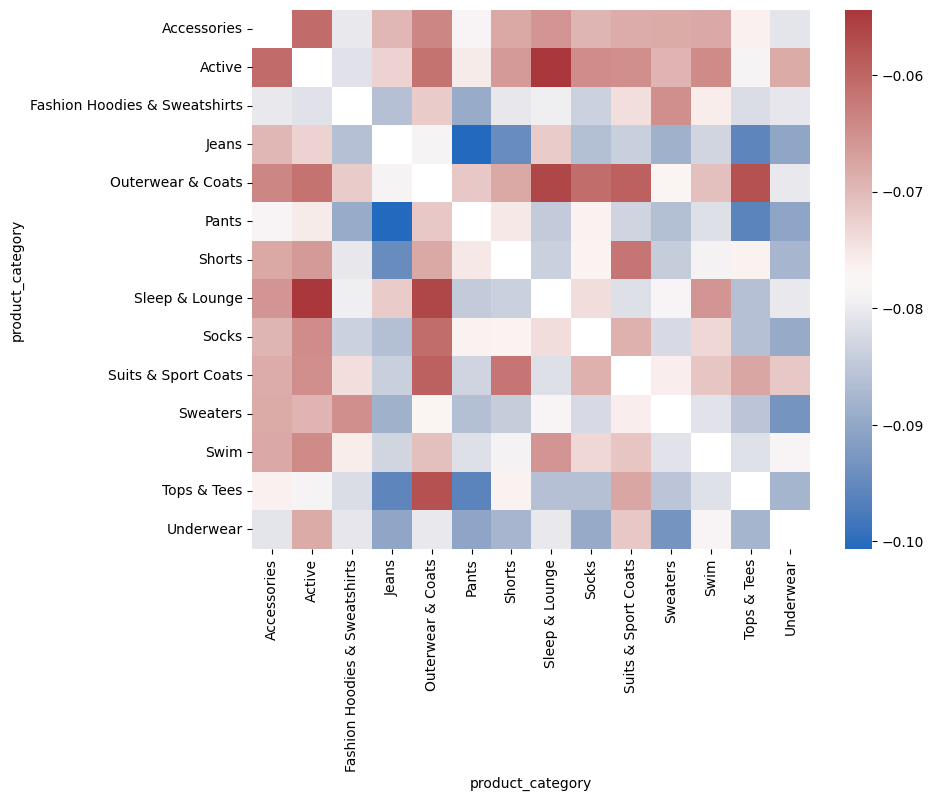

In [67]:
plt.figure(figsize=(9,7))
X_cats_corr = X_cats_m.corr()
m_diag = np.diag(np.diag(np.ones(X_cats_corr.shape, np.bool)))
X_cats_corr.values[m_diag] = None
sns.heatmap(X_cats_corr, cmap='vlag')

<Axes: xlabel='product_category', ylabel='product_category'>

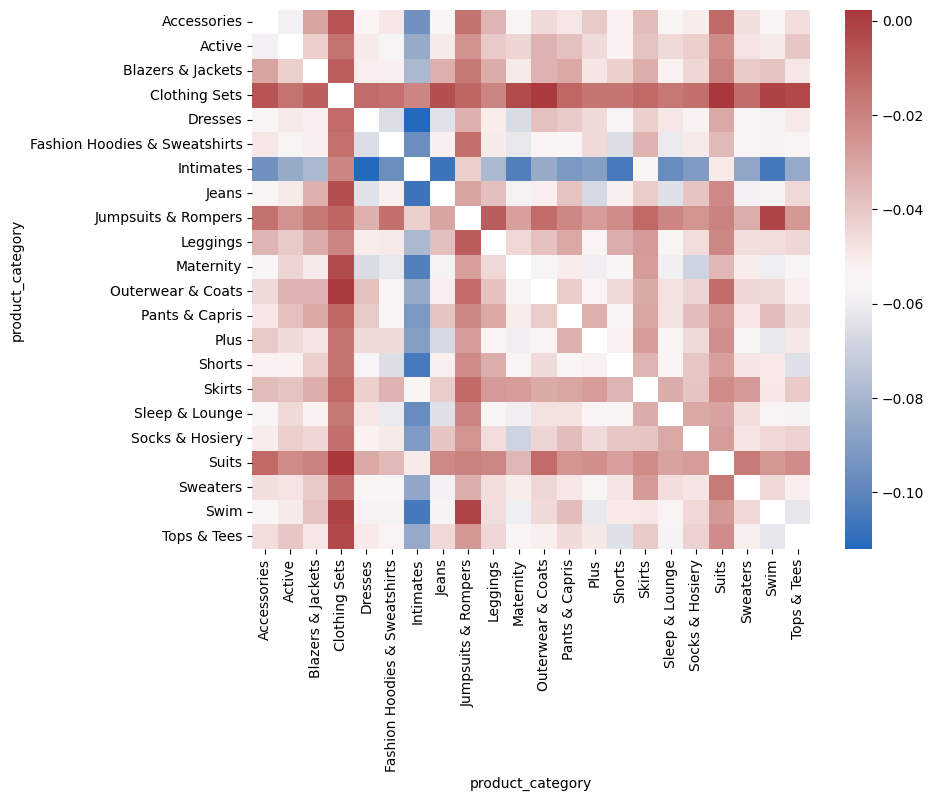

In [68]:
plt.figure(figsize=(9,7))
X_cats_corr = X_cats_f.corr()
m_diag = np.diag(np.diag(np.ones(X_cats_corr.shape, np.bool)))
X_cats_corr.values[m_diag] = None
sns.heatmap(X_cats_corr, cmap='vlag')

# Dimensionality Reduction with Autoencoders

In [69]:
X_cats = X_cats_m

In [70]:
X_cats[X_cats==0] = 0
X_cats[X_cats>0] = 1

In [72]:
idx = np.arange(X_cats.shape[0])

train_idx, test_idx = train_test_split(idx, test_size=0.1, random_state=RANDOM_STATE)
train_idx, valid_idx = train_test_split(train_idx, test_size=0.1, random_state=RANDOM_STATE)

X_train = X_cats.iloc[train_idx]
X_valid = X_cats.iloc[valid_idx]
X_test = X_cats.iloc[test_idx]

In [73]:
scaler_autoencoder = MinMaxScaler()
X_train_scaled = scaler_autoencoder.fit_transform(X_train)
X_valid_scaled = scaler_autoencoder.transform(X_valid)
X_test_scaled = scaler_autoencoder.transform(X_test)
X_pred_scaled = np.concat([X_train_scaled, X_valid_scaled, X_test_scaled])

X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
X_valid_scaled = torch.tensor(X_valid_scaled, dtype=torch.float32)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)
X_pred_scaled = torch.tensor(X_pred_scaled, dtype=torch.float32)

dataset_train = TensorDataset(X_train_scaled)
train_loader = DataLoader(dataset_train, batch_size=256, shuffle=True)

dataset_valid = TensorDataset(X_valid_scaled)
valid_loader = DataLoader(dataset_valid, batch_size=256, shuffle=True)

In [76]:
ae = AutoEncoder([X_train.shape[1], 12, 6])
ae.encoder, ae.decoder

(Sequential(
   (0): Linear(in_features=14, out_features=12, bias=True)
   (1): ReLU()
   (2): Linear(in_features=12, out_features=6, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=6, out_features=12, bias=True)
   (1): ReLU()
   (2): Linear(in_features=12, out_features=14, bias=True)
   (3): Sigmoid()
 ))

In [77]:
trainer = AETrainer(ae, lr_reduce_patience=5)
trainer.train(train_loader, valid_loader, early_stop_threshold=20)

Using device: cpu
Epoch 1/1000, Validation Loss: 0.636054218
Epoch 2/1000, Validation Loss: 0.579880908
Epoch 3/1000, Validation Loss: 0.512248784
Epoch 4/1000, Validation Loss: 0.493646190
Epoch 5/1000, Validation Loss: 0.475883633
Epoch 6/1000, Validation Loss: 0.455288142
Epoch 7/1000, Validation Loss: 0.430384532
Epoch 8/1000, Validation Loss: 0.406493425
Epoch 9/1000, Validation Loss: 0.384642042
Epoch 10/1000, Validation Loss: 0.367483050
Epoch 11/1000, Validation Loss: 0.350438438
Epoch 12/1000, Validation Loss: 0.336343870
Epoch 13/1000, Validation Loss: 0.320943266
Epoch 14/1000, Validation Loss: 0.310831703
Epoch 15/1000, Validation Loss: 0.302863926
Epoch 16/1000, Validation Loss: 0.294797376
Epoch 17/1000, Validation Loss: 0.289016828
Epoch 18/1000, Validation Loss: 0.285569921
Epoch 19/1000, Validation Loss: 0.284028463
Epoch 20/1000, Validation Loss: 0.278485358
Epoch 21/1000, Validation Loss: 0.271818288
Epoch 22/1000, Validation Loss: 0.264171802
Epoch 23/1000, Validati

np.float64(0.08142806403338909)

In [78]:
mse_loss = torch.nn.MSELoss()

encoded, decoded = ae(X_test_scaled)
test_loss = mse_loss(decoded, X_test_scaled)
test_loss

tensor(0.0245, grad_fn=<MseLossBackward0>)

In [79]:
mse_loss = torch.nn.MSELoss()

encoded, decoded = ae(X_pred_scaled)
pred_loss = mse_loss(decoded, X_pred_scaled)
pred_loss

tensor(0.0233, grad_fn=<MseLossBackward0>)

In [80]:
np.sqrt(pred_loss.detach().numpy())

np.float32(0.15263894)

In [81]:
X_encoded = encoded.detach().numpy()

In [82]:
X_encoded

array([[-3.805013  , -1.0213429 ,  6.596273  , -0.9028495 , -3.2070847 ,
        -2.9746234 ],
       [-2.4319007 , -7.657181  ,  7.465999  , -2.3582559 , -5.8318825 ,
        -3.4383717 ],
       [-1.0662589 ,  1.4851843 , -2.2329433 , -3.0450957 ,  2.0248528 ,
        -2.4847476 ],
       ...,
       [ 8.515672  , -2.6151528 ,  5.2201977 ,  2.289872  , -1.1518859 ,
        -2.5914462 ],
       [ 3.1926897 , -5.883227  ,  8.427415  , -0.48277742,  2.8120313 ,
         0.52842313],
       [ 4.841159  , -5.459987  ,  9.302187  , -7.3999987 ,  3.2867746 ,
        -1.5484877 ]], dtype=float32)

In [83]:
pd.DataFrame(X_encoded).describe()

,0,1,2,3,4,5
count,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000,10249.000000
mean,2.046252,-2.257272,4.893228,-3.288518,0.972920,-1.317356
std,3.549381,3.630123,3.751444,2.954601,3.183588,2.272212
min,-8.879115,-11.925183,-4.604043,-11.581823,-10.564375,-11.845469
25%,0.112799,-5.026155,1.971356,-5.473871,-1.151886,-2.642973
50%,2.223726,-2.388515,4.662703,-3.198548,1.182323,-1.244744
75%,4.495884,0.499905,7.604469,-1.015983,3.205530,0.279597
max,10.182646,9.177294,17.473591,6.317024,8.754567,4.006027


# Explaining Encodings with LRP

In [84]:
def make_explanation_df(X, lrp_out, encoded):
    input_np =  X.values
    lrp_np = lrp_out.numpy()
    encoded_np = encoded.detach().numpy()
    data_explain = np.concat([input_np, lrp_np, encoded_np], axis=1)
    
    len_encoding = encoded_np.shape[1]
    input_cols = X.columns.tolist()
    relevance_cols = [f'rel_{col}' for col in input_cols]
    encoding_cols = [f'encoding_{i}' for i in range(len_encoding)]
    explanation_cols = input_cols + relevance_cols + encoding_cols
    columns_map = dict(
        input_cols = input_cols,
        relevance_cols = relevance_cols,
        encoding_cols = encoding_cols
    )
    
    df_explain = pd.DataFrame(data_explain, columns=explanation_cols)
    return df_explain, columns_map

In [85]:
def explanation_corrs(df_explain, columns_map):
    input_cols = columns_map.get('input_cols')
    relevance_cols = columns_map.get('relevance_cols')
    encoding_cols = columns_map.get('encoding_cols')
    
    input_relevance_corr = np.diagonal(df_explain.corr().loc[input_cols, relevance_cols])
    data_input_relevance = {
        'column': input_cols,
        'input_relevance_correlation': input_relevance_corr
    }
    input_relevance_corr = pd.DataFrame(data_input_relevance).sort_values('input_relevance_correlation', ascending=False)

    df_explain_corr = df_explain.corr()
    
    relevance_encoding_corr = df_explain_corr.loc[relevance_cols, encoding_cols].values
    relevance_encoding_corr = pd.DataFrame(relevance_encoding_corr, index=relevance_cols, columns=encoding_cols)
    
    encoding_corr = df_explain_corr.loc[encoding_cols, encoding_cols].values
    encoding_corr = pd.DataFrame(encoding_corr, index=encoding_cols, columns=encoding_cols)

    corr_dfs = dict(
        input_relevance_corr = input_relevance_corr, 
        relevance_encoding_corr = relevance_encoding_corr,
        encoding_corr = encoding_corr
    )
    
    return corr_dfs

In [86]:
def plot_explanation_corrs(input_relevance_corr, encoding_corr, relevance_encoding_corr):    
    fig = plt.figure(figsize=(7, 7))
    ax = sns.heatmap(input_relevance_corr.set_index('column'), cmap='vlag')
    ax.set_title('Input - Relevance Correlations')
    
    fig = plt.figure(figsize=(7, 7))
    ax = sns.heatmap(relevance_encoding_corr, cmap='vlag')
    ax.set_title('Relevance - Encoding Correlations')

    fig = plt.figure(figsize=(7, 7))
    encoding_corr_copy = encoding_corr.copy()
    m_diag = np.diag(np.diag(np.ones(encoding_corr_copy.shape, np.bool)))
    encoding_corr_copy.values[m_diag] = None
    ax = sns.heatmap(encoding_corr_copy, cmap='vlag')
    ax.set_title('Encoding Correlations')

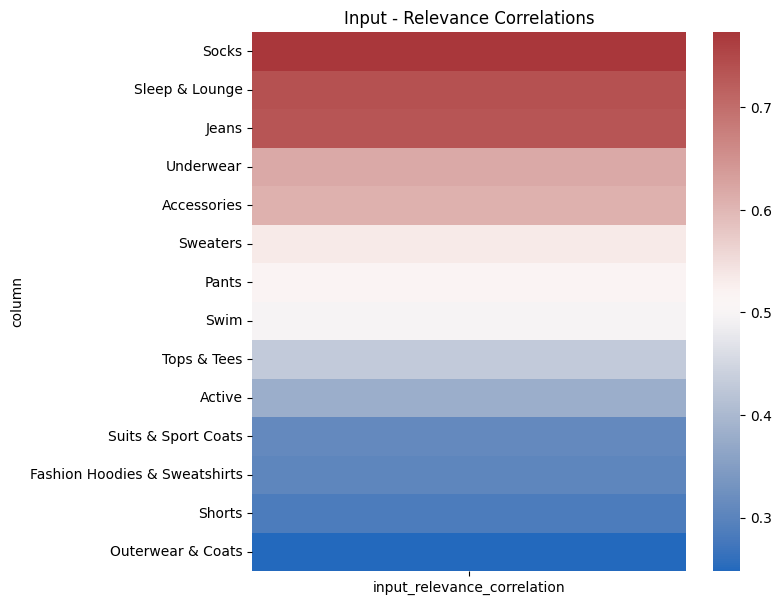

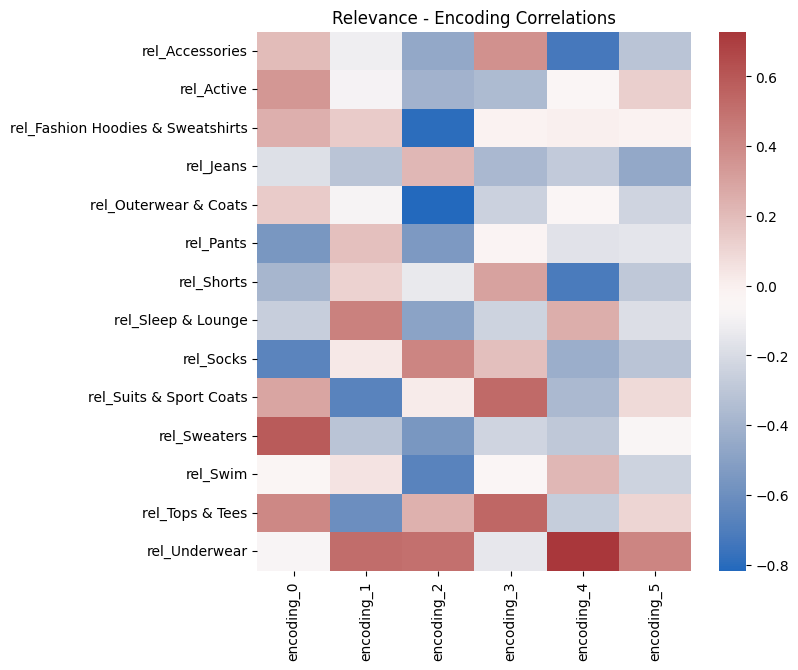

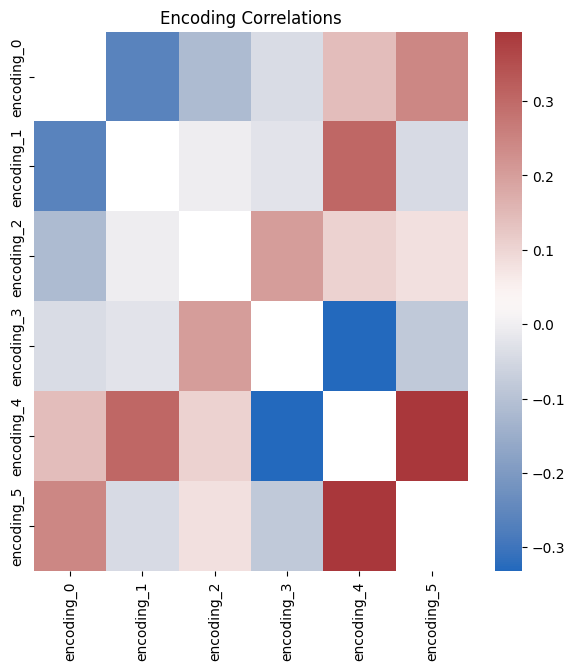

In [87]:
encoded, decoded = ae(X_pred_scaled)

lrp = LinearLRP(ae.encoder, top_k=1)
lrp_out = lrp(X_pred_scaled)

df_pred_scaled = pd.DataFrame(X_pred_scaled.numpy(), columns=X_test.columns)
df_explain, columns_map = make_explanation_df(df_pred_scaled, lrp_out, encoded)
corr_dfs = explanation_corrs(df_explain, columns_map)
plot_explanation_corrs(**corr_dfs)

# Clustering Customers by Encodings

In [88]:
def model_results_to_df(results, explode_hyperparams=True):
    df = pd.DataFrame(results)
    if explode_hyperparams:
        df_hyperparams = pd.DataFrame(df['hyperparams'].tolist())
        df = pd.concat([df, df_hyperparams], axis=1)\
                .drop(columns='hyperparams')
    return df

def search_clustering_hyperparams(model_type, hyperparams, X, random_state=None, verbose=True, explode_hyperparams=True):
    results = []
    for hyperparams_iter in hyperparams:
        if random_state:
            hyperparams_iter['random_state'] = random_state
            
        model = model_type(**hyperparams_iter)
        y = model.fit_predict(X)

        if np.unique(y).shape[0] > 1:
            silhouette = silhouette_score(X, y)
        else:
            silhouette = -1
        
        if model_type == KMeans:
            error = model.inertia_ 
        else:
            error = None
            
        results_dict = { 
            'hyperparams': hyperparams_iter, 
            'model': model,
            'silhouette_score': silhouette,
            'error': error
        }
        
        
        results.append(results_dict)

        if verbose:
            print(hyperparams_iter, f'Silhouette Score: {silhouette}', f'Error: {error}', sep=' | ')

    df_results = model_results_to_df(results, explode_hyperparams=True)
    
    return df_results

In [89]:
def plot_clusters(X, y, figwidth=15, figheight=10, bins=20):
    X = pd.DataFrame(X) if type(X) != pd.DataFrame else X
    labels = np.unique(y)

    fig, axs = plt.subplots(len(labels), len(X.columns))
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.suptitle('Cluster Feature Histograms')
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    col_mins = {}
    col_maxs = {}
    col_means = {}
    for col in X.columns:
        col_mins[col] = X[col].min()
        col_maxs[col] = X[col].max()
        col_means[col] = X[col].mean()

    for i, label in enumerate(labels):
        X_cluster = X.loc[y==label]
        for j, col in enumerate(X.columns):        
            ax = axs[i,j]
            ax.set_xlim(col_mins[col], col_maxs[col])
            if j == 0:
                ax.set_ylabel(label)
            if i == len(labels) - 1:
                ax.set_xlabel(col)
            
            X_cluster[col].hist(ax=ax, bins=bins)
            cluster_col_mean = X_cluster[col].mean()
            ymax = pd.cut(X_cluster[col], bins).value_counts().max()
            ax.vlines(cluster_col_mean, ymin=0, ymax=ymax, color='tab:orange', label='Cluster Mean')
            ax.vlines(col_means[col], ymin=0, ymax=ymax, color='tab:red', label='Sample Mean')

    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

In [90]:
scaler_kmeans = MinMaxScaler()
X_scaled = scaler_kmeans.fit_transform(X_encoded)
X_scaled

array([[0.26619273, 0.516709  , 0.50731504, 0.59662914, 0.38083294,
        0.559622  ],
       [0.33822766, 0.20225129, 0.54670906, 0.51531625, 0.24496642,
        0.5303662 ],
       [0.40987068, 0.63548785, 0.10739829, 0.47694284, 0.651652  ,
        0.59052604],
       ...,
       [0.91254884, 0.4411819 , 0.4449861 , 0.7750049 , 0.48721552,
        0.58379495],
       [0.6332996 , 0.28631505, 0.5902561 , 0.62009835, 0.6923984 ,
        0.78061354],
       [0.71978   , 0.30637145, 0.62987864, 0.23363653, 0.7169724 ,
        0.6495905 ]], dtype=float32)

In [91]:
pca_category = PCA(n_components='mle')
X_pca = pca_category.fit_transform(X_encoded)
X_pca

array([[ 3.6532655 , -6.2105865 , -3.4632878 , -0.25971413,  0.11556768],
       [-2.1054769 , -9.186231  , -2.0862634 , -3.6025674 , -0.77933717],
       [ 1.9958633 ,  3.6418853 , -7.271357  ,  1.0796846 ,  2.0108836 ],
       ...,
       [-4.2001505 , -1.9013646 ,  2.0355363 ,  7.168252  , -1.1363571 ],
       [-1.370599  , -2.2659652 ,  5.160942  ,  0.09638214,  2.667742  ],
       [-1.5349631 ,  1.0108713 ,  5.8125105 , -3.7965953 , -2.7789152 ]],
      dtype=float32)

In [92]:
pca_category.explained_variance_ratio_

array([0.2694535 , 0.24563679, 0.22254348, 0.13324912, 0.07835632],
      dtype=float32)

In [93]:
X_pca.shape

(10249, 5)

In [94]:
hyperparams = [{'n_clusters': i} for i in range(2, 16)]
kmeans_results = search_clustering_hyperparams(KMeans, hyperparams, X_pca, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.19300609827041626 | Error: 501892.15625
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.25220733880996704 | Error: 373834.9375
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.2873016595840454 | Error: 300169.5
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.2654630243778229 | Error: 274357.03125
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.2628049850463867 | Error: 254390.0625
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.2549031972885132 | Error: 237051.8125
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.266122043132782 | Error: 212562.921875
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.2627054750919342 | Error: 202481.46875
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.27027246356010437 | Error: 188917.09375
{'n_clusters': 11, 'random_state': 42} | Silhouette Score: 0.28680455684661865 | Error: 173566.859375
{'n_cluste

<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

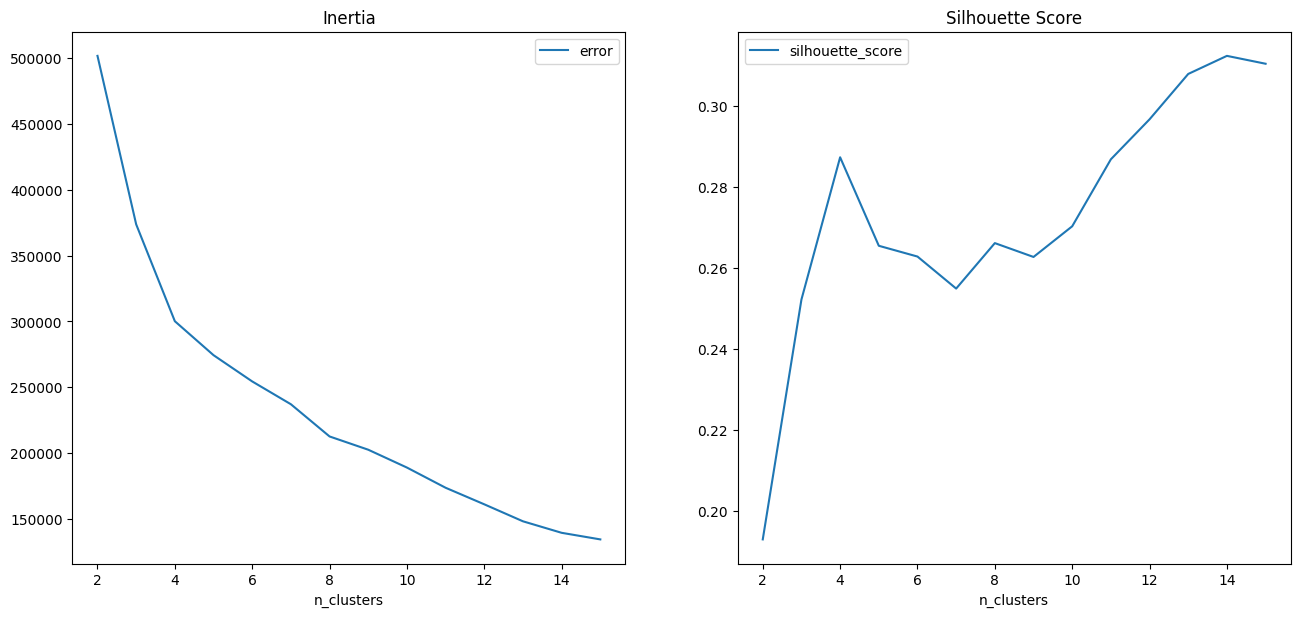

In [95]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)
 
axs[0].set_title('Inertia')
kmeans_results.plot(x='n_clusters', y='error', ax=axs[0])

axs[1].set_title('Silhouette Score')
kmeans_results.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [96]:
kmeans = kmeans_results.loc[kmeans_results.n_clusters==4, 'model'].iloc[0]
labels = kmeans.labels_

In [97]:
pd.Series(labels).value_counts()

1    3617
2    3412
3    1952
0    1268
Name: count, dtype: int64

In [98]:
Xy = pd.DataFrame(X_encoded)
Xy['segment'] = labels

Xy_cats = pd.DataFrame(X_cats_m)
Xy_cats['segment'] = labels

Xy_cats_bin = pd.DataFrame(X_cats_m > 0).astype(int)
Xy_cats_bin['segment'] = labels

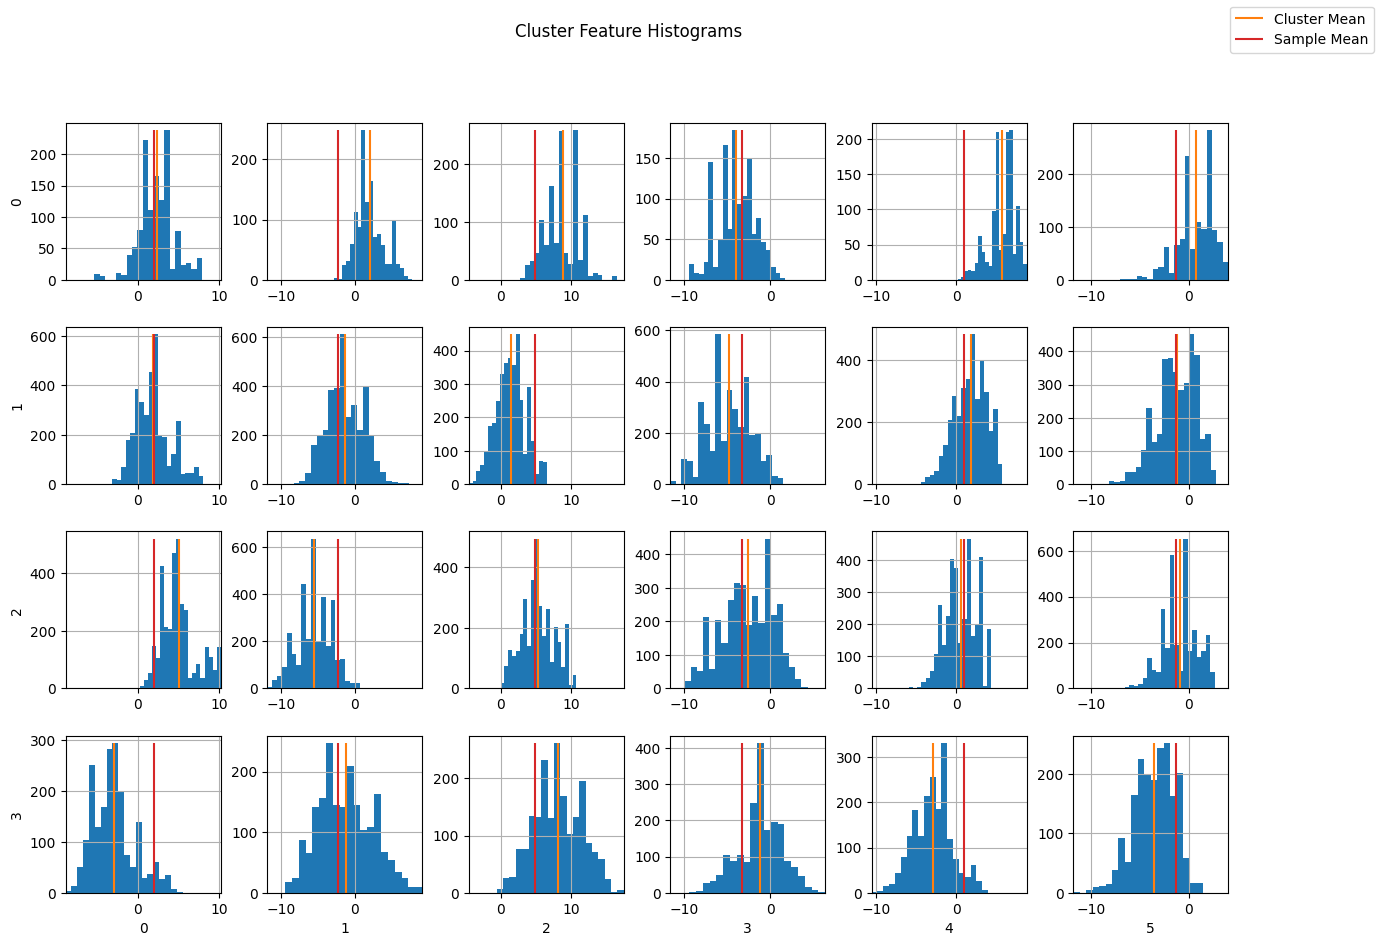

In [99]:
plot_clusters(Xy.drop(columns='segment'), Xy['segment'])

# Profiling Clusters

[Text(0.5, 1.0, 'Segment Means - Norm. by Overall Mean')]

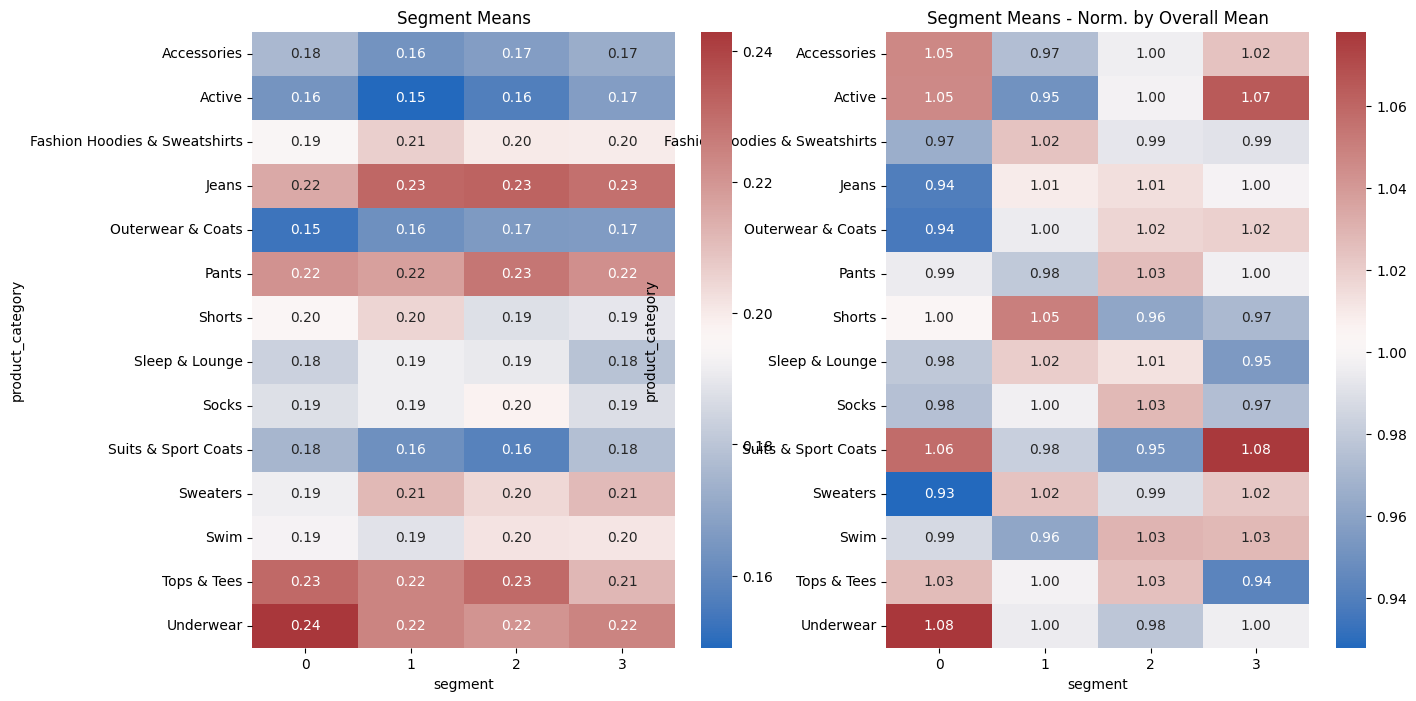

In [100]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

sns.heatmap(Xy_cats.groupby('segment').mean().T, cmap='vlag', annot=True, fmt='.2f', ax=axs[0])
axs[0].set(title='Segment Means')

cluster_means_norm = Xy_cats.groupby('segment').mean() / Xy_cats.drop(columns='segment').mean()
sns.heatmap(
    cluster_means_norm.T, 
    cmap='vlag',
    annot=True, 
    fmt='.2f', 
    ax=axs[1]
)
axs[1].set(title='Segment Means - Norm. by Overall Mean')

[Text(0.5, 1.0, 'Percentage Customers Purchased - Norm. by Overall Percent.')]

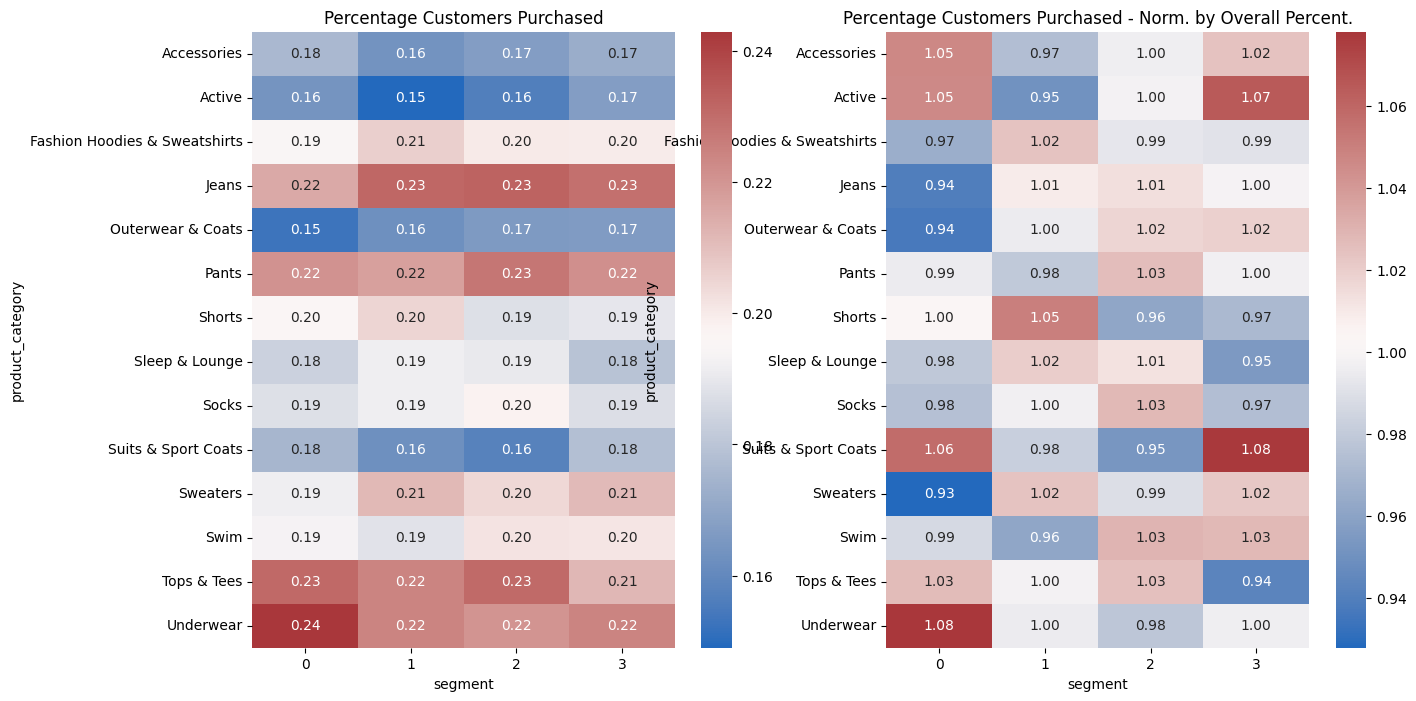

In [101]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

sns.heatmap(Xy_cats_bin.groupby('segment').mean().T, cmap='vlag', annot=True, fmt='.2f', ax=axs[0])
axs[0].set(title='Percentage Customers Purchased')

cluster_means_norm = Xy_cats_bin.groupby('segment').mean() / Xy_cats_bin.drop(columns='segment').mean()
sns.heatmap(cluster_means_norm.T, cmap='vlag', annot=True, fmt='.2f', ax=axs[1])
axs[1].set(title='Percentage Customers Purchased - Norm. by Overall Percent.')

[Text(0.5, 1.0, 'Segment Relevance Means - Norm. by Overall Mean')]

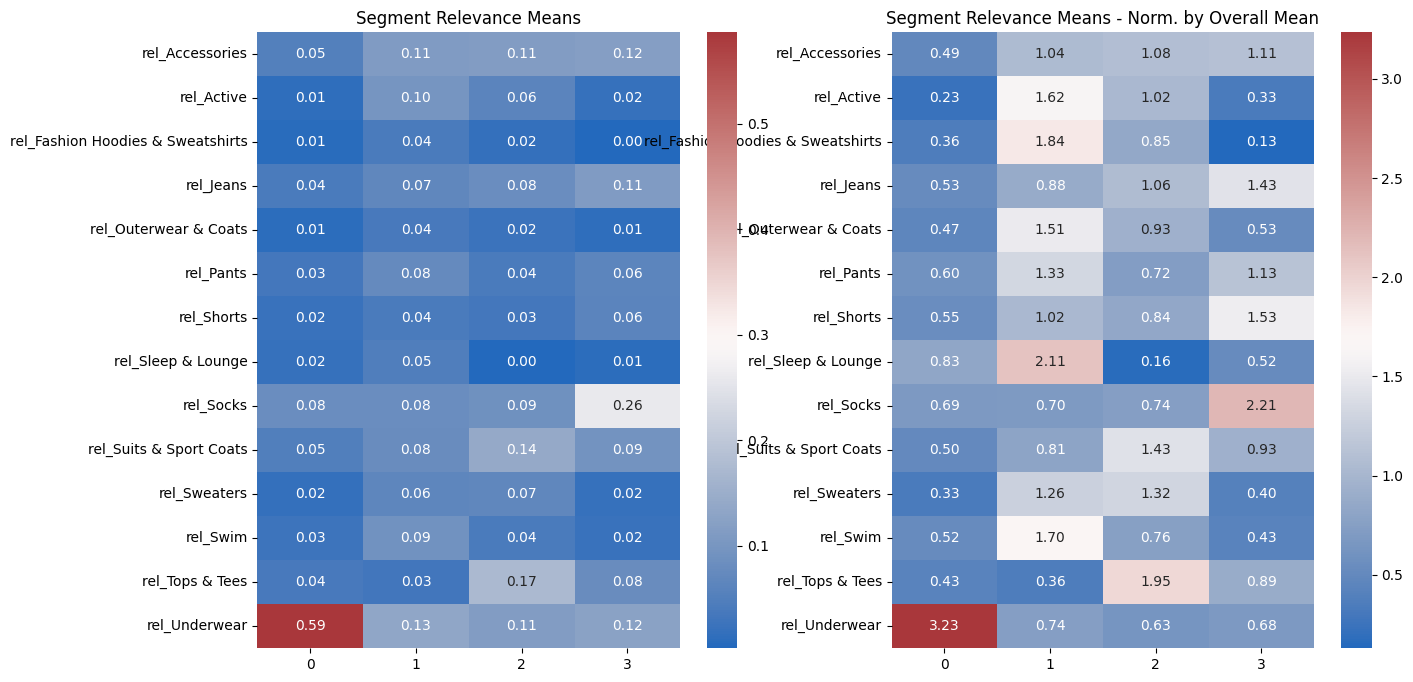

In [102]:
rel_cols = [col for col in df_explain.columns if col.startswith('rel_')]
X_rel = df_explain[rel_cols]

fig, axs = plt.subplots(1,2, figsize=(15,8))

sns.heatmap(X_rel.groupby(labels).mean().T, cmap='vlag', annot=True, fmt='.2f', ax=axs[0])
axs[0].set(title='Segment Relevance Means')

cluster_means_norm = X_rel.groupby(labels).mean() / X_rel.mean()
sns.heatmap(
    cluster_means_norm.T, 
    cmap='vlag',
    annot=True, 
    fmt='.2f', 
    ax=axs[1]
)
axs[1].set(title='Segment Relevance Means - Norm. by Overall Mean')

In [103]:
centroids_encoded = pca_category.inverse_transform(kmeans.cluster_centers_)
centroids_encoded = scaler_kmeans.inverse_transform(centroids_encoded)
centroids_encoded = torch.tensor(centroids_encoded)
centroids_decoded = ae.decoder(centroids_encoded).detach().numpy()
centroids_decoded = scaler_autoencoder.inverse_transform(centroids_decoded)
centroids_decoded = pd.DataFrame(centroids_decoded, columns=X_cats.columns)

[Text(0.5, 1.0, 'Centroids Decoded - Norm. by Mean')]

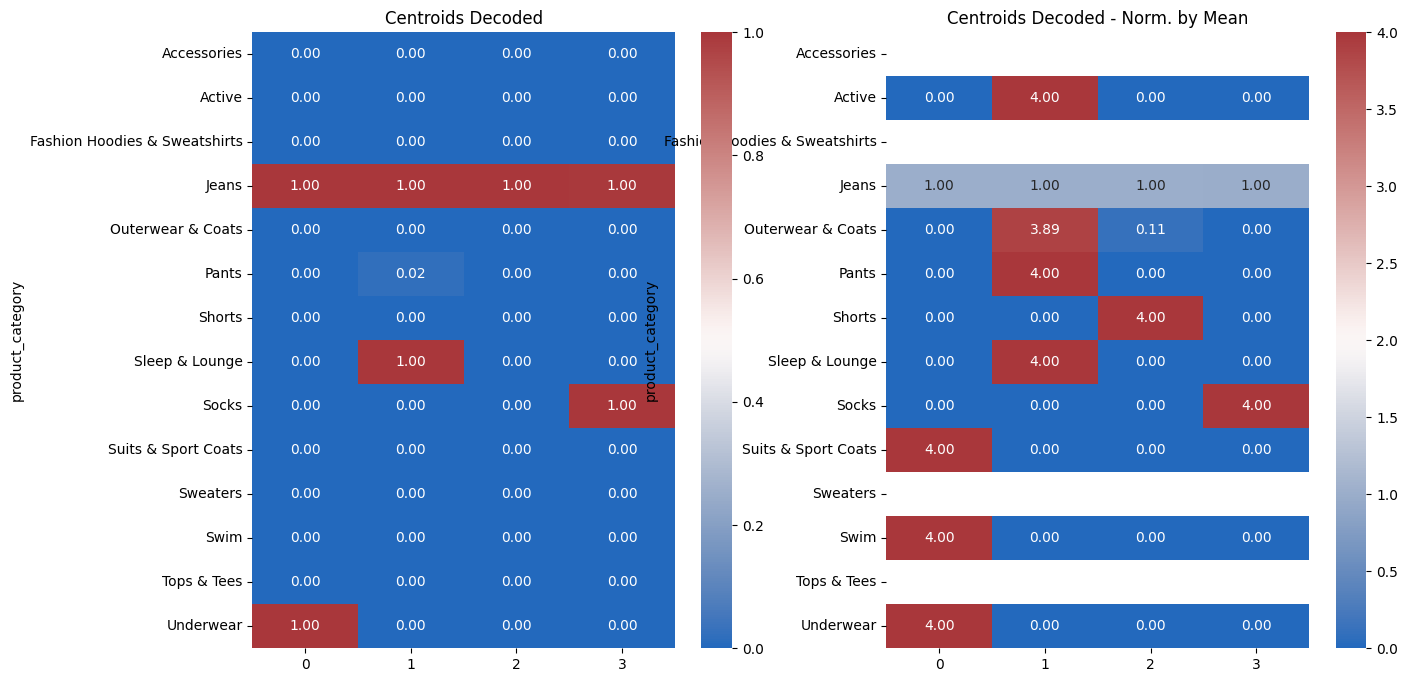

In [104]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

sns.heatmap(centroids_decoded.T, cmap='vlag', annot=True, fmt='.2f', ax=axs[0])
axs[0].set(title='Centroids Decoded')

cluster_means_norm = centroids_decoded / centroids_decoded.mean().abs()
sns.heatmap(
    cluster_means_norm.T, 
    cmap='vlag',
    annot=True, 
    fmt='.2f',
    ax=axs[1]
)
axs[1].set(title='Centroids Decoded - Norm. by Mean')

In [105]:
Xy_cats_bin.loc[Xy_cats_bin.segment==1].head(20)

product_category,Accessories,Active,Fashion Hoodies & Sweatshirts,Jeans,Outerwear & Coats,Pants,Shorts,Sleep & Lounge,Socks,Suits & Sport Coats,Sweaters,Swim,Tops & Tees,Underwear,segment
user_id,,,,,,,,,,,,,,,
3,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1
98318,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
39,1,0,0,0,0,1,1,0,1,0,0,0,0,1,1
32807,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
65577,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
48,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
49,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1
54,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
32822,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1


In [537]:
m_category_segment_map = {
    0: 'Jeans, Tops & Tees, Fashion Hoodies & Sweatshirts',
    1: 'Mixed | Swim',
    2: 'Jeans, Pants',
    3: 'Pants, Underwear',
    4: 'Jeans, Pants, Tops & Tees, Sweaters',
    5: 'Jeans, Swim, Accesories, Active'
}

# Saving Pipelines

In [ ]:
category_segment_pipe = Pipeline([('scaler', kmeans_scaler), ('kmeans', kmeans)])

In [ ]:
# with open('../models/category_segment_pipe.pkl', 'wb') as f:
#     pkl.dump(category_segment_pipe, f)

In [ ]:
with open('../models/category_segment_pipe.pkl', 'rb') as f:
    category_segment_pipe_loaded = pkl.load(f)

In [ ]:
labels = category_segment_pipe_loaded.predict(X_scaled)
(labels == kmeans.labels_).all()

In [ ]:
with open('../models/category_segment_map.json', 'w') as f:
    json.dump(category_segment_map, f)

In [ ]:
with open('../models/category_segment_map.json', 'r') as f:
    category_segment_map_loaded = json.load(f)

In [ ]:
category_segment_map